# Models 3
- This notebook attempts to improve performance from the second [modeling notebook](./models_2.ipynb).
- We will use PyTorch sequence NNs to complete this task.
- Each input sequence must be of at least length __n__, with season __n+1__ offensive grade as the target.
- For players who only have a single season with a target, we'll have to use the Random Forest found in [this notebook](./models_1.ipynb).

## Imports, Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pytorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# sklearn packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Bayesian optimization
from bayes_opt import BayesianOptimization

# dataframe display
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# seaborn theme
sns.set_theme(context='talk', style='whitegrid')

# global random_state
random_state = 9

In [2]:
# set up GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [6]:
# master_df contains entire dataset
master_df = pd.read_csv('./train_data/data.csv').drop(['Unnamed: 0'], axis=1)

In [7]:
# 2022 players with 2023 target (test set)
players_2022 = master_df[master_df['year'] == 2022]

# 'df' holds all non-2022 rows
df = master_df.drop(players_2022.index)

# Functions 

## Create Sequences
- Pack data into 2-year sequences with 3rd year offensive grade as target.

In [18]:
def create_seq(feature_subset, seq_len, df):
    '''
    
    
    Pack data into sequences of seq_len NFL seasons. Return features and target variables.
    
    Parameters:
    feature_subset (list) - list of column names to use from dataframe
    seq_len (int) - number of seasons to use to predict the target
    df (pandas.DataFrame) - dataframe to create the sequences from
    
    Returns:
    X (numpy.ndarray) - features
    y (numpy.ndarray) - targets
    
    
    
    '''
    
    # get players with at least seq_len seasons
    df_grouped = df.groupby('player').filter(lambda x: len(x) >= seq_len)

    # create a new df subset
    df_subset = df_grouped[['player', 'target'] + feature_subset]

    sequences = []
    labels = []

    # iterate over each player
    for player, group in df_subset.groupby('player'):
        # iterate over the group to create sequences
        for i in range((len(group) - seq_len) + 1):
            # each sequence is a list of rows/features from two consecutive seasons
            sequence = group.iloc[i:(i + seq_len)].drop(['player', 'target'], axis=1).to_dict('records')
            
            # the label is the 'target' col from the final season in sequence
            label = group.iloc[i + seq_len - 1]['target']
            
            sequences.append(sequence)
            labels.append(label)

    # unpack the dicts in each sequence, fill null values with 0
    unpacked_sequences = [[[val for val in list(d.values())] for d in sequence] for sequence in sequences]   

    # convert sequences and labels into np array
    X = np.array(unpacked_sequences)
    y = np.array(labels)

    
    
    return X, y

### Look at different sequence lengths

In [19]:
cols = df.drop(['player', 'team_name', 'year', 'target'], axis=1).columns.tolist()

for seq_len in [2, 3, 4, 5]:
    X, y = create_seq(feature_subset=cols, seq_len=seq_len, df=df)
    print(f'Using sequences of {seq_len} seasons:')
    print(f'Shape of X = {X.shape}')
    print(f'Shape of y = {y.shape}')
    print()

Using sequences of 2 seasons:
Shape of X = (752, 2, 66)
Shape of y = (752,)

Using sequences of 3 seasons:
Shape of X = (579, 3, 66)
Shape of y = (579,)

Using sequences of 4 seasons:
Shape of X = (452, 4, 66)
Shape of y = (452,)

Using sequences of 5 seasons:
Shape of X = (350, 5, 66)
Shape of y = (350,)



- When using sequences of 2 seasons to predict 3rd, we have 752 training examples. As we increase sequence length, the size of the training set gets smaller and smaller.
- This may be problematic in the training process, as our models won't have very much training data.

## Standardize the Data
- sklearn.StandardScaler only accepts 2-dimensional data as input. The following function addresses this and returns the proper 3D matrices.

In [20]:
# StandardScaler won't accept 3-dimensional data as input, so we create a function
def standardize_3d(X_train, X_val=None):
    '''
    
    Reshapes X array from 3D to 2D and standardizes.
    
    Parameters
    X_train (np.array) - X_train array
    X_val: (np.array) - X_val array
    
    Returns
    X_train_standardized_3d (np.array) - standardized X_train array in 3-dimensional form
    X_val_standardized_3d (np.array) - standardized X_val array in 3-dimensional form
    
    '''
    
    if isinstance(X_val, np.ndarray):
        # reshape the data to be 2D -> (n_samples * n_time_steps, n_features)
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
        X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

        # create scaler, fit on the training data
        scaler = StandardScaler()
        scaler.fit(X_train_reshaped)

        # transform the data
        X_train_standardized_2d = scaler.transform(X_train_reshaped)
        X_val_standardized_2d = scaler.transform(X_val_reshaped)

        # reshape back to 3D
        X_train_standardized_3d = X_train_standardized_2d.reshape(X_train.shape)
        X_val_standardized_3d = X_val_standardized_2d.reshape(X_val.shape)

        return X_train_standardized_3d, X_val_standardized_3d
    
    else:
        # reshape the data to be 2D -> (n_samples * n_time_steps, n_features)
        X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])

        # create scaler, fit on the training data
        scaler = StandardScaler()
        scaler.fit(X_train_reshaped)

        # transform the data
        X_train_standardized_2d = scaler.transform(X_train_reshaped)

        # reshape back to 3D
        X_train_standardized_3d = X_train_standardized_2d.reshape(X_train.shape)

        return X_train_standardized_3d

## Create Dataloaders
- Use standardize_3d to standardize the sequences. Convert sequences and labels into pytorch-friendly dataloaders for training.

In [280]:
def create_loaders(X, y, batch_size, test_size, random_state=random_state):
    '''
    
    
    Split data into train and val sets, standardize data, return training and valing dataloaders.
    
    Parameters:
    X (numpy.ndarray) - features
    y (numpy.ndarray) - targets
    batch_size (int) - batch size to be used in the training dataloader
    test_size (float) - percentage of data to be set aside as validation set
    
    
    Returns:
    train_loader (torch.utils.data.DataLoader) - train dataloader
    val_loader (torch.utils.data.DataLoader) - val dataloader 
    
    
    
    '''
    
    
    
    # typecast for compatibility
    y = y.astype('float32')
    
    if test_size > 0:
        # train/val split
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # standardize the data
        X_train_standardized, X_val_standardized = standardize_3d(X_train, X_val)

        # convert sequences and labels into tensors
        X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val_standardized, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

        # datasets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        # dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=X_val_tensor.shape[0], shuffle=False)

        return train_loader, val_loader
    
    # single dataloaders for final generalization stage
    else:
        # standardize the data
        X_train_standardized = standardize_3d(X)

        # convert sequences and labels into tensors
        X_train_tensor = torch.tensor(X_train_standardized, dtype=torch.float32)
        y_train_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

        # datasets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

        # dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        return train_loader

## Train loop
- Train model on training data, evaluate on test data

In [58]:
def train_val(model, optimizer, train_loader, val_loader, patience=15, device=device):
    
    # loss function
    criterion = nn.MSELoss()
    
    # 500 epochs
    num_epochs = 500

    # early stopping
    stopped = False
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    # training loop
    for epoch in range(num_epochs):
        # training mode
        model.train()

        # sum of squared error, preds, and y. reset at the start of every epoch
        sse = 0
        epoch_preds = []
        epoch_y = []

        # train batches
        for x, y in train_loader:
            # put x and y on gpu
            x = x.to(device)
            y = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            train_preds = model(x)
            # calc loss
            train_loss = criterion(train_preds, y)
            # backward pass
            train_loss.backward()
            # optimize
            optimizer.step()

            # accumulate squared errors
            sse += ((train_preds - y) ** 2).sum().item()

            # get preds and y from batch to calc r2
            epoch_preds.extend(train_preds.numpy(force=True))
            epoch_y.extend(y.numpy(force=True))

        # train metrics
        train_rmse = np.sqrt(sse / len(train_loader.dataset))
        train_r2 = r2_score(epoch_y, epoch_preds)



        # validation
        model.eval()

        with torch.inference_mode():
            # val loop (single batch)
            for x, y in val_loader:
                # put x and y on gpu
                x = x.to(device)
                y = y.to(device)
                
                # forward pass
                val_preds = model(x)
                # calc loss
                val_loss = criterion(val_preds, y)

        # val metrics
        val_rmse = np.sqrt(((val_preds - y) ** 2).sum().item() / y.shape[0])
        val_r2 = r2_score(y.numpy(force=True), val_preds.numpy(force=True))

    
    
        # early stopping
        if val_rmse < best_val_loss:
            best_val_loss = val_rmse
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

            # break out of train loop if we reach patience value
            if epochs_without_improvement == patience:
                stopped = True
                stopped_epoch = epoch + 1
                print(f'Early stopping on Epoch {stopped_epoch}.')
                break



    # get number of epochs that the model was trained for            
    if stopped:
        num_epochs = stopped_epoch



    return train_rmse, train_r2, val_rmse, val_r2, num_epochs, patience

# Sequence models
- 3 unique recurrent neural network architectures

In [59]:
# recurrent neural network
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1, dropout=0):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out
    
    
    
# long-short-term-memory rnn
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1, dropout=0):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out
    
    
    
# gated-recurrent-unit rnn
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1, dropout=0):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

# Bayesian Optimization
- Iterating through parameter space to find best sequence model
- I want to find the best model for each specific sequence length. I will perform a round of Bayesian optimization for sequences of 2, 3, and 4 seasons.

In [66]:
# all features
all_feats = df.drop(['player', 'team_name', 'year', 'target'], axis=1).columns.tolist()

## seq_len = 2
- Use 2 seasons to predict a QB's grade in the 3rd.

In [67]:
def objective_function(hidden_dim, num_layers, dropout, batch_size):
    # cast continuous values to int
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    batch_size = int(batch_size)
    
    # create sequences
    X, y = create_seq(feature_subset=all_feats, seq_len=2, df=df)
    
    # create dataloaders
    train_loader, val_loader = create_loaders(X, y, test_size=0.1, batch_size=batch_size)

    # create model
    model = RNN(input_dim=66, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
        
    # create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # train model
    train_rmse, train_r2, val_rmse, val_r2, num_epochs, patience = train_val(model, optimizer, train_loader, val_loader)
    
    # return the negative of the validation metric (since Bayesian optimization minimizes)
    return -val_rmse

In [68]:
# define bounds of each hyperparameter
pbounds = {
    'hidden_dim': (4, 1025),
    'num_layers': (2, 17),
    'dropout': (0, 0.9),
    'batch_size': (1, 129)
}

# create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random_state,
    allow_duplicate_points=True
)

In [69]:
# iterate through feature space
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | batch_... |  dropout  | hidden... | num_la... |
-------------------------------------------------------------------------
Early stopping on Epoch 20.
| 1         | -13.31    | 2.328     | 0.4517    | 510.2     | 4.007     |
Early stopping on Epoch 93.
| 2         | -12.43    | 19.19     | 0.1967    | 431.3     | 5.722     |
Early stopping on Epoch 54.
| 3         | -13.34    | 11.76     | 0.3109    | 174.3     | 15.18     |
Early stopping on Epoch 21.
| 4         | -72.67    | 122.7     | 0.03487   | 717.8     | 10.59     |
Early stopping on Epoch 73.
| 5         | -13.32    | 115.9     | 0.6002    | 563.3     | 12.54     |
Early stopping on Epoch 39.
| 6         | -14.19    | 50.47     | 0.625     | 846.2     | 8.985     |
Early stopping on Epoch 151.
| 7         | -12.06    | 121.4     | 0.7234    | 1.008e+03 | 4.545     |
Early stopping on Epoch 28.
| 8         | -13.3     | 67.7      | 0.851     | 667.2     | 14.91     |
Early stopping on Epoch 88.
| 9    

Early stopping on Epoch 208.
| 56        | -13.33    | 90.87     | 0.2738    | 134.4     | 16.37     |
Early stopping on Epoch 63.
| 57        | -12.27    | 26.34     | 0.9       | 209.5     | 2.0       |
Early stopping on Epoch 32.
| 58        | -13.28    | 41.07     | 0.9       | 749.1     | 17.0      |
Early stopping on Epoch 75.
| 59        | -12.38    | 76.71     | 0.9       | 581.6     | 2.0       |
Early stopping on Epoch 469.
| 60        | -13.34    | 128.5     | 0.8691    | 60.56     | 13.48     |
Early stopping on Epoch 42.
| 61        | -12.95    | 1.0       | 0.0       | 346.2     | 2.0       |
Early stopping on Epoch 16.
| 62        | -67.17    | 88.12     | 0.0       | 851.2     | 17.0      |
Early stopping on Epoch 62.
| 63        | -12.23    | 92.22     | 0.9       | 791.9     | 2.0       |
Early stopping on Epoch 354.
| 64        | -13.33    | 88.78     | 0.9       | 63.16     | 17.0      |
Early stopping on Epoch 216.
| 65        | -13.33    | 70.41     | 0.4259    | 

In [70]:
# look at params that gave lowest validation RMSE
best_hyperparams = optimizer.max['params']
best_hyperparams

{'batch_size': 32.03638856422199,
 'dropout': 0.9,
 'hidden_dim': 100.74795411866992,
 'num_layers': 2.0}

- Best val_rmse = __11.87__ with a sequence length of 2.

## seq_len = 3
- Use 3 seasons to predict a QB's grade in the 4th.

In [74]:
def objective_function(hidden_dim, num_layers, dropout, batch_size):
    # cast continuous values to int
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    batch_size = int(batch_size)
    
    # create sequences
    X, y = create_seq(feature_subset=all_feats, seq_len=3, df=df)
    
    # create dataloaders
    train_loader, val_loader = create_loaders(X, y, test_size=0.1, batch_size=batch_size)

    # create model
    model = RNN(input_dim=66, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
        
    # create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # train model
    train_rmse, train_r2, val_rmse, val_r2, num_epochs, patience = train_val(model, optimizer, train_loader, val_loader)
    
    # return the negative of the validation metric (since Bayesian optimization minimizes)
    return -val_rmse

In [75]:
# define bounds of each hyperparameter
pbounds = {
    'hidden_dim': (4, 1025),
    'num_layers': (2, 17),
    'dropout': (0, 0.9),
    'batch_size': (1, 129)
}

# create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random_state,
    allow_duplicate_points=True
)

In [76]:
# iterate through feature space
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | batch_... |  dropout  | hidden... | num_la... |
-------------------------------------------------------------------------
Early stopping on Epoch 32.
| 1         | -20.11    | 2.328     | 0.4517    | 510.2     | 4.007     |
Early stopping on Epoch 34.
| 2         | -21.17    | 19.19     | 0.1967    | 431.3     | 5.722     |
Early stopping on Epoch 27.
| 3         | -13.28    | 11.76     | 0.3109    | 174.3     | 15.18     |
Early stopping on Epoch 23.
| 4         | -67.22    | 122.7     | 0.03487   | 717.8     | 10.59     |
Early stopping on Epoch 44.
| 5         | -13.2     | 115.9     | 0.6002    | 563.3     | 12.54     |
Early stopping on Epoch 22.
| 6         | -22.06    | 50.47     | 0.625     | 846.2     | 8.985     |
Early stopping on Epoch 27.
| 7         | -21.3     | 121.4     | 0.7234    | 1.008e+03 | 4.545     |
Early stopping on Epoch 27.
| 8         | -13.38    | 67.7      | 0.851     | 667.2     | 14.91     |
Early stopping on Epoch 89.
| 9     

Early stopping on Epoch 127.
| 55        | -12.77    | 87.0      | 0.9       | 112.3     | 17.0      |
Early stopping on Epoch 151.
| 56        | -12.74    | 76.28     | 0.9       | 100.8     | 2.0       |
Early stopping on Epoch 167.
| 57        | -12.73    | 103.7     | 0.1333    | 111.9     | 3.599     |
Early stopping on Epoch 199.
| 58        | -12.71    | 94.11     | 0.07921   | 91.99     | 10.58     |
Early stopping on Epoch 161.
| 59        | -12.73    | 72.55     | 0.0       | 86.05     | 17.0      |
Early stopping on Epoch 118.
| 60        | -14.33    | 53.53     | 0.7182    | 85.1      | 2.6       |
Early stopping on Epoch 58.
| 61        | -13.06    | 25.37     | 0.4154    | 113.4     | 15.21     |
Early stopping on Epoch 147.
| 62        | -12.74    | 120.5     | 0.8718    | 140.4     | 5.255     |
Early stopping on Epoch 177.
| 63        | -12.71    | 116.9     | 0.0       | 122.2     | 17.0      |
Early stopping on Epoch 194.
| 64        | -12.71    | 114.3     | 0.9    

Early stopping on Epoch 31.
| 110       | -13.26    | 17.88     | 0.0634    | 197.3     | 8.175     |


In [77]:
# look at params that gave lowest validation RMSE
best_hyperparams = optimizer.max['params']
best_hyperparams

{'batch_size': 27.646390417997868,
 'dropout': 0.9,
 'hidden_dim': 98.40961269063185,
 'num_layers': 2.0}

- Best val_rmse = __11.13__ with a sequence length of 3.

## seq_len = 4
- Use 4 seasons to predict a QB's grade in the 5th.

In [84]:
def objective_function(hidden_dim, num_layers, dropout, batch_size):
    # cast continuous values to int
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    batch_size = int(batch_size)
    
    # create sequences
    X, y = create_seq(feature_subset=all_feats, seq_len=4, df=df)
    
    # create dataloaders
    train_loader, val_loader = create_loaders(X, y, test_size=0.1, batch_size=batch_size)

    # create model
    model = RNN(input_dim=66, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
        
    # create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # train model
    train_rmse, train_r2, val_rmse, val_r2, num_epochs, patience = train_val(model, optimizer, train_loader, val_loader)
    
    # return the negative of the validation metric (since Bayesian optimization minimizes)
    return -val_rmse

In [85]:
# define bounds of each hyperparameter
pbounds = {
    'hidden_dim': (4, 1025),
    'num_layers': (2, 17),
    'dropout': (0, 0.9),
    'batch_size': (1, 129)
}

# create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random_state,
    allow_duplicate_points=True
)

In [86]:
# iterate through feature space
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | batch_... |  dropout  | hidden... | num_la... |
-------------------------------------------------------------------------
Early stopping on Epoch 23.
| 1         | -21.99    | 2.328     | 0.4517    | 510.2     | 4.007     |
Early stopping on Epoch 34.
| 2         | -17.54    | 19.19     | 0.1967    | 431.3     | 5.722     |
Early stopping on Epoch 33.
| 3         | -17.59    | 11.76     | 0.3109    | 174.3     | 15.18     |
Early stopping on Epoch 25.
| 4         | -61.11    | 122.7     | 0.03487   | 717.8     | 10.59     |
Early stopping on Epoch 58.
| 5         | -17.56    | 115.9     | 0.6002    | 563.3     | 12.54     |
Early stopping on Epoch 26.
| 6         | -49.18    | 50.47     | 0.625     | 846.2     | 8.985     |
Early stopping on Epoch 35.
| 7         | -17.58    | 121.4     | 0.7234    | 1.008e+03 | 4.545     |
Early stopping on Epoch 32.
| 8         | -17.63    | 67.7      | 0.851     | 667.2     | 14.91     |
Early stopping on Epoch 129.
| 9    

Early stopping on Epoch 361.
| 55        | -17.48    | 128.2     | 0.3241    | 87.51     | 14.84     |
Early stopping on Epoch 58.
| 56        | -17.55    | 99.0      | 0.9       | 470.4     | 2.0       |
Early stopping on Epoch 40.
| 57        | -17.56    | 40.04     | 0.0       | 389.1     | 2.0       |
Early stopping on Epoch 118.
| 58        | -17.52    | 92.03     | 0.6746    | 233.6     | 2.713     |
Early stopping on Epoch 37.
| 59        | -17.79    | 97.71     | 0.9       | 636.3     | 17.0      |
Early stopping on Epoch 30.
| 60        | -15.72    | 2.805     | 0.3892    | 138.5     | 2.072     |
Early stopping on Epoch 29.
| 61        | -17.68    | 55.56     | 0.9       | 635.1     | 17.0      |
Early stopping on Epoch 34.
| 62        | -17.73    | 1.0       | 0.9       | 641.9     | 17.0      |
Early stopping on Epoch 238.
| 63        | -17.49    | 93.27     | 0.9       | 103.5     | 2.0       |
Early stopping on Epoch 38.
| 64        | -17.54    | 34.49     | 0.6408    | 4

Early stopping on Epoch 85.
| 110       | -17.52    | 127.3     | 0.4212    | 379.3     | 15.49     |


In [87]:
# look at params that gave lowest validation RMSE
best_hyperparams = optimizer.max['params']
best_hyperparams

{'batch_size': 2.431643963415951,
 'dropout': 0.6090968014817699,
 'hidden_dim': 328.7250817317628,
 'num_layers': 2.895291334711312}

- Best val_rmse = __13.46__ with a sequence length of 4.

## seq_len = 5
- Use 5 seasons to predict a QB's grade in the 6th.

In [88]:
def objective_function(hidden_dim, num_layers, dropout, batch_size):
    # cast continuous values to int
    hidden_dim = int(hidden_dim)
    num_layers = int(num_layers)
    batch_size = int(batch_size)
    
    # create sequences
    X, y = create_seq(feature_subset=all_feats, seq_len=5, df=df)
    
    # create dataloaders
    train_loader, val_loader = create_loaders(X, y, test_size=0.1, batch_size=batch_size)

    # create model
    model = RNN(input_dim=66, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
        
    # create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    
    # train model
    train_rmse, train_r2, val_rmse, val_r2, num_epochs, patience = train_val(model, optimizer, train_loader, val_loader)
    
    # return the negative of the validation metric (since Bayesian optimization minimizes)
    return -val_rmse

In [89]:
# define bounds of each hyperparameter
pbounds = {
    'hidden_dim': (4, 1025),
    'num_layers': (2, 17),
    'dropout': (0, 0.9),
    'batch_size': (1, 129)
}

# create the Bayesian optimizer
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds=pbounds,
    random_state=random_state,
    allow_duplicate_points=True
)

In [90]:
# iterate through feature space
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | batch_... |  dropout  | hidden... | num_la... |
-------------------------------------------------------------------------
Early stopping on Epoch 16.
| 1         | -66.28    | 2.328     | 0.4517    | 510.2     | 4.007     |
Early stopping on Epoch 37.
| 2         | -69.12    | 19.19     | 0.1967    | 431.3     | 5.722     |
Early stopping on Epoch 62.
| 3         | -14.98    | 11.76     | 0.3109    | 174.3     | 15.18     |
Early stopping on Epoch 108.
| 4         | -14.99    | 122.7     | 0.03487   | 717.8     | 10.59     |
Early stopping on Epoch 106.
| 5         | -14.98    | 115.9     | 0.6002    | 563.3     | 12.54     |
Early stopping on Epoch 37.
| 6         | -16.49    | 50.47     | 0.625     | 846.2     | 8.985     |
Early stopping on Epoch 56.
| 7         | -16.12    | 121.4     | 0.7234    | 1.008e+03 | 4.545     |
Early stopping on Epoch 61.
| 8         | -14.88    | 67.7      | 0.851     | 667.2     | 14.91     |
Early stopping on Epoch 97.
| 9   

Early stopping on Epoch 25.
| 55        | -37.28    | 120.0     | 0.5997    | 1.006e+03 | 5.629     |
Early stopping on Epoch 61.
| 56        | -14.97    | 73.1      | 0.7794    | 668.2     | 11.37     |
Early stopping on Epoch 71.
| 57        | -14.9     | 70.06     | 0.8736    | 669.3     | 7.606     |
Early stopping on Epoch 66.
| 58        | -14.99    | 67.18     | 0.7824    | 667.1     | 11.23     |
Early stopping on Epoch 84.
| 59        | -15.17    | 71.45     | 0.5836    | 670.7     | 7.918     |
Early stopping on Epoch 39.
| 60        | -57.81    | 66.2      | 0.2433    | 668.4     | 9.256     |
Early stopping on Epoch 51.
| 61        | -15.14    | 72.7      | 0.07599   | 672.3     | 7.703     |
Early stopping on Epoch 62.
| 62        | -14.87    | 75.07     | 0.8951    | 659.3     | 12.82     |
Early stopping on Epoch 69.
| 63        | -14.97    | 72.76     | 0.5178    | 661.5     | 14.82     |
Early stopping on Epoch 55.
| 64        | -14.98    | 72.18     | 0.8317    | 668.

Early stopping on Epoch 85.
| 110       | -15.01    | 74.67     | 0.7724    | 668.7     | 16.55     |


In [91]:
# look at params that gave lowest validation RMSE
best_hyperparams = optimizer.max['params']
best_hyperparams

{'batch_size': 69.52339713727007,
 'dropout': 0.8680468665981138,
 'hidden_dim': 670.8489740824233,
 'num_layers': 9.719175317016374}

- Best val_rmse = __14.83__ with a sequence length of 5.

## Optimization results

- As sequence length was increased above 3, validation performance continued to decrease.
- seq_len of both 2 and 3 performed pretty well, and will both be used to predict in the next section.

# 2023 predictions
- This model will be trained on the entire train/val data, and then will predict 2023 offensive grade from the 2022 holdout set.
- Since we are using a sequence length of 2 seasons to predict the third, we will use 2021 & 2022 seasons (to predict 2022 target) as the test set.
- This means that players with under 3 seasons played can't be predicted on. I will use the best model (Random Forest) from [this notebook](./models_1.ipynb) to make these predictions.

## seq_len = 2

In [97]:
# get the names of the 48 players that have 2023 targets
player_names_2023 = players_2022.player.values

# master_df includes 2022 rows. create a subset for these players, get players with at least 2 seasons
players_subset = master_df[master_df['player'].isin(player_names_2023)]
players_subset = players_subset.groupby('player').filter(lambda x: len(x) >= 2)

# get last two rows for each player
seq_test = players_subset.groupby('player').apply(lambda x: x.tail(2)).reset_index(drop=True)

In [98]:
# train sequences
X_train, y_train = create_seq(feature_subset=all_feats, seq_len=2, df=df)

# test sequences
X_test, y_test = create_seq(feature_subset=all_feats, seq_len=2, df=seq_test)

In [99]:
# 752 total examples to train on, 42 QBs to predict on
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((752, 2, 66), (752,), (42, 2, 66), (42,))

In [100]:
# create dataloaders
train_loader = create_loaders(X_train, y_train, test_size=0, batch_size=32)
test_loader = create_loaders(X_test, y_test, test_size=0, batch_size=len(X_test))

In [169]:
# best sequence model
best_seq = RNN(input_dim=len(all_feats), hidden_dim=98, num_layers=2, dropout=0.9).to(device)

# create optimizer
optimizer = torch.optim.AdamW(best_seq.parameters(), lr=0.001)

In [170]:
# loss function
criterion = nn.MSELoss()

# 100 epochs
num_epochs = 100

# training mode
best_seq.train()

# training loop
for epoch in range(num_epochs):  
    # train batches
    for x, y in train_loader:
        # put x and y on gpu
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        train_preds = best_seq(x)
        # calc loss
        train_loss = criterion(train_preds, y)
        # backward pass
        train_loss.backward()
        # optimize
        optimizer.step()

In [171]:
# test set
best_seq.eval()

with torch.inference_mode():
    for x, y in test_loader:
        # put x and y on gpu
        x = x.to(device)
        y = y.to(device)

        # forward pass
        test_preds = best_seq(x)
        # calc loss
        test_loss = criterion(test_preds, y)

        # performance metrics
        rmse = np.sqrt(((test_preds - y) ** 2).sum().item() / y.shape[0])
        r2 = r2_score(y.numpy(force=True), test_preds.numpy(force=True))

print(f'RMSE: {rmse:.3f}')
print(f'R^2: {r2:.3f}')

RMSE: 12.895
R^2: 0.317


- On the 42/48 QBs who have 3+ seasons played, our model predicts their 2023 offensive grade with an RMSE of 12.895.

In [172]:
# get 2022 players who can't be predicted on with sequence model (players with less than 2 seasons)
players_subset = master_df[master_df['player'].isin(player_names_2023)]
players_subset = players_subset.groupby('player').filter(lambda x: len(x) < 2)

# get last row for each player
non_seq_test = players_subset.groupby('player').apply(lambda x: x.tail(1)).reset_index(drop=True)
non_seq_test.shape

(6, 70)

- 6 QBs in 2023 with less than 3 seasons played.

In [173]:
# best random forest
best_rf = RandomForestRegressor(random_state=random_state, min_samples_split=112)

# features and target
X_train = df[all_feats]
y_train = df.target
X_test = non_seq_test[all_feats]
y_test = non_seq_test.target

# create pieline
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', best_rf)
    ])

# train on entire dataset
pipeline.fit(X_train, y_train)

# predict
preds = pipeline.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print(f'RMSE: {rmse:.3f}')
print(f'R^2: {r2:.3f}')

RMSE: 11.658
R^2: 0.245


In [194]:
# combine preds from the two models
y_pred = np.concatenate([test_preds.squeeze(-1).cpu().numpy(), preds])

# get true values
y_true = np.concatenate([y.squeeze(-1).cpu().numpy(), y_test])

# look at overall performance
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'R^2: {r2:.3f}')

RMSE: 12.747
R^2: 0.338


- Using an RNN with a sequence length of 2 (paired with best Random Forest), we achieve a RMSE of __12.75__.
- This is worse performance than just the Random Forest from [models_1](./models_1.ipynb).

## seq_len = 3

In [281]:
# get players with at least 3 seasons
players_subset = master_df[master_df['player'].isin(player_names_2023)]
players_subset = players_subset.groupby('player').filter(lambda x: len(x) >= 3)

# get last two rows for each player
seq_test = players_subset.groupby('player').apply(lambda x: x.tail(3)).reset_index(drop=True)

In [282]:
# train sequences
X_train, y_train = create_seq(feature_subset=all_feats, seq_len=3, df=df)

# test sequences
X_test, y_test = create_seq(feature_subset=all_feats, seq_len=3, df=seq_test)

In [283]:
# 579 total examples to train on, 36 QBs to predict on
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((579, 3, 66), (579,), (36, 3, 66), (36,))

In [284]:
# create dataloaders
train_loader = create_loaders(X_train, y_train, test_size=0, batch_size=28)
test_loader = create_loaders(X_test, y_test, test_size=0, batch_size=len(X_test))

In [285]:
# best sequence model
best_seq = RNN(input_dim=len(all_feats), hidden_dim=98, num_layers=2, dropout=0.9).to(device)

# create optimizer
optimizer = torch.optim.AdamW(best_seq.parameters(), lr=0.001)

In [286]:
# loss function
criterion = nn.MSELoss()

# 100 epochs
num_epochs = 100

# training mode
best_seq.train()

# training loop
for epoch in range(num_epochs):  
    # train batches
    for x, y in train_loader:
        # put x and y on gpu
        x = x.to(device)
        y = y.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        train_preds = best_seq(x)
        # calc loss
        train_loss = criterion(train_preds, y)
        # backward pass
        train_loss.backward()
        # optimize
        optimizer.step()

In [287]:
# test set
best_seq.eval()

with torch.inference_mode():
    for x, y in test_loader:
        # put x and y on gpu
        x = x.to(device)
        y = y.to(device)

        # forward pass
        test_preds = best_seq(x)
        # calc loss
        test_loss = criterion(test_preds, y)

        # performance metrics
        rmse = np.sqrt(((test_preds - y) ** 2).sum().item() / y.shape[0])
        r2 = r2_score(y.numpy(force=True), test_preds.numpy(force=True))

print(f'RMSE: {rmse:.3f}')
print(f'R^2: {r2:.3f}')

RMSE: 13.131
R^2: 0.337


- On the 36/48 QBs who have 4+ seasons played, our model predicts their 2023 offensive grade with an RMSE of 13.13.

In [288]:
# get 2022 players who can't be predicted on with sequence model (players with less than 3 seasons)
players_subset = master_df[master_df['player'].isin(player_names_2023)]
players_subset = players_subset.groupby('player').filter(lambda x: len(x) < 3)

# get last row for each player
non_seq_test = players_subset.groupby('player').apply(lambda x: x.tail(1)).reset_index(drop=True)
non_seq_test.shape

(12, 70)

- 12 QBs in 2023 with less than 4 seasons played.

In [289]:
# best random forest
best_rf = RandomForestRegressor(random_state=random_state, min_samples_split=112)

# features and target
X_train = df[all_feats]
y_train = df.target
X_test = non_seq_test[all_feats]
y_test = non_seq_test.target

# create pieline
pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', best_rf)
    ])

# train on entire dataset
pipeline.fit(X_train, y_train)

# predict
preds = pipeline.predict(X_test)

rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print(f'RMSE: {rmse:.3f}')
print(f'R^2: {r2:.3f}')

RMSE: 10.578
R^2: 0.356


In [290]:
# combine preds from the two models
y_pred = np.concatenate([test_preds.squeeze(-1).cpu().numpy(), preds])

# get true values
y_true = np.concatenate([y.squeeze(-1).cpu().numpy(), y_test])

# look at overall performance
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)
print(f'RMSE: {rmse:.3f}')
print(f'R^2: {r2:.3f}')

RMSE: 12.541
R^2: 0.359


- Using an RNN with a sequence length of 2 (paired with best Random Forest), we achieve a RMSE of __12.54__. This is slightly better performance to the seq_len=2 model.
- Once again, this is worse than the Random Forest found initially in the modeling process.

## Visualize predictions
- Even though these models won't be used as the final predictors, I would still like to see how they predicted differently on specific players.

In [291]:
# player names
player_names = seq_test.player.unique().tolist() + non_seq_test.player.unique().tolist()

# teams
team_names = []
for _, group in seq_test.groupby('player'):
    team_names.append(group.iloc[-1].team_name)

team_names.extend(non_seq_test.team_name.tolist())

In [292]:
preds_df = pd.DataFrame(data={'player': player_names, 'team': team_names, 'y_true': y_true, 'y_pred': y_pred, 
                              'error': (y_pred - y_true)})

In [293]:
# team colors for plotting predictions
nfl_team_colors = {
    'GB': '#203731',   # Green Bay Packers
    'NO': '#D3BC8D',   # New Orleans Saints
    'LA': '#003594',   # Los Angeles Rams
    'DAL': '#041E42',  # Dallas Cowboys
    'NYG': '#0B2265',  # New York Giants
    'LV': '#000000',   # Las Vegas Raiders
    'SEA': '#002244',  # Seattle Seahawks
    'PHI': '#004C54',  # Philadelphia Eagles
    'DET': '#0076B6',  # Detroit Lions
    'SF': '#AA0000',   # San Francisco 49ers
    'CIN': '#FB4F14',  # Cincinnati Bengals
    'BUF': '#00338D',  # Buffalo Bills
    'CHI': '#0B162A',  # Chicago Bears
    'LAC': '#0080C6',  # Los Angeles Chargers
    'PIT': '#FFB612',  # Pittsburgh Steelers
    'MIN': '#4F2683',  # Minnesota Vikings
    'ARZ': '#97233F',  # Arizona Cardinals
    'BLT': '#241773',  # Baltimore Ravens
    'NE': '#002244',   # New England Patriots
    'KC': '#E31837',   # Kansas City Chiefs
    'DEN': '#FB4F14',  # Denver Broncos
    'TEN': '#0C2340',  # Tennessee Titans
    'WAS': '#773141',  # Washington Commanders
    'JAX': '#006778',  # Jacksonville Jaguars
    'MIA': '#008E97',  # Miami Dolphins
    'NYJ': '#125740',  # New York Jets
    'TB': '#D50A0A',   # Tampa Bay Buccaneers
    'CLV': '#311D00',  # Cleveland Browns
    'ATL': '#A71930',  # Atlanta Falcons
    'CAR': '#0085CA',  # Carolina Panthers
}

# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(nfl_team_colors)

In [294]:
# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)

print(f'{percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

58.3% of our model's predictions are within 10 pts of the true value.


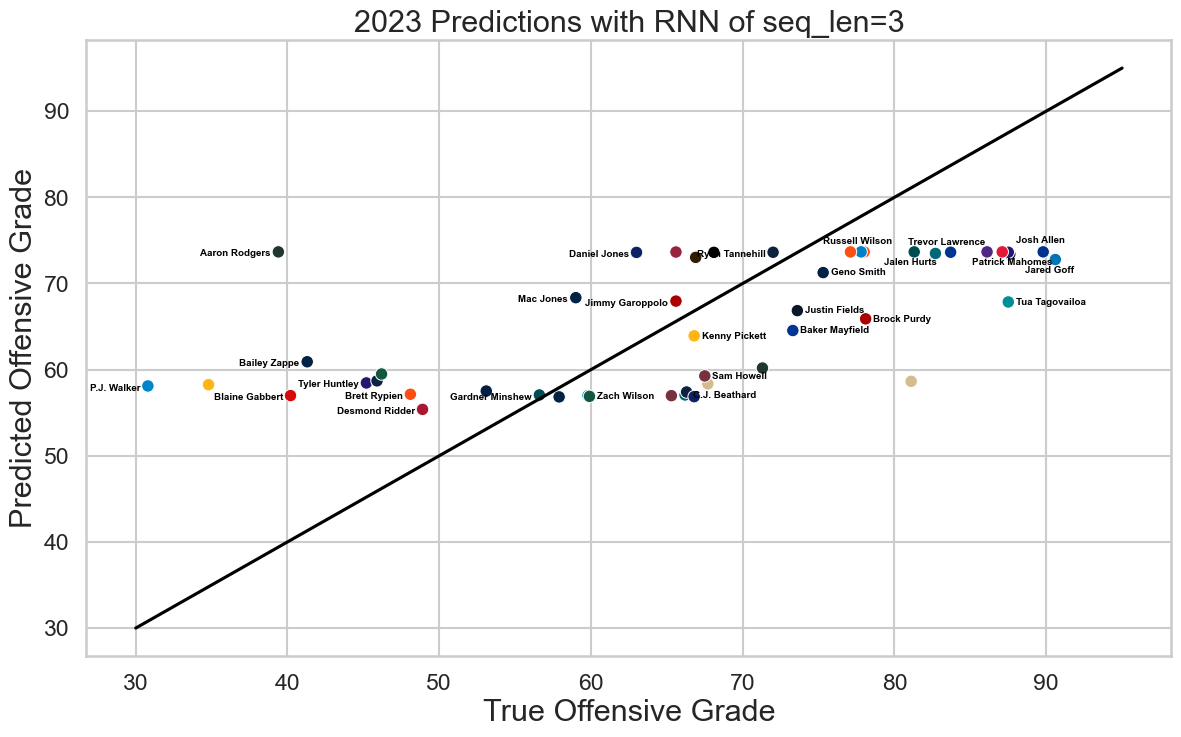

In [332]:
# visualize 2023 predictions
plt.figure(figsize=(14, 8))

# lists for annotating player names
over_drops = ['Mike White', 'Cooper Rush', 'Malik Willis', 'Deshaun Watson', 'Mitch Trubisky', 'Kyler Murray', 'Derek Carr']
under_drops = ['Jameis Winston', 'Taylor Heinicke', 'Brian Hoyer', 'Andy Dalton', 'Dak Prescott', 'Joshua Dobbs', 
               'Lamar Jackson', 'Jordan Love', 'Sam Darnold', 'Tyrod Taylor', 'Joe Burrow', 'Russell Wilson', 'Justin Herbert', 
               'Jalen Hurts', 'Patrick Mahomes', 'Jared Goff', 'Lamar Jackson', 'Trevor Lawrence', 'Matthew Stafford', 
               'Kirk Cousins', 'Josh Allen']
over_position = ['Russell Wilson', 'Trevor Lawrence', 'Josh Allen']
under_position = ['Jalen Hurts', 'Patrick Mahomes', 'Jared Goff']

# title, labels
plt.title('2023 Predictions with RNN of seq_len=3', fontsize=22)
plt.xlabel('True Offensive Grade', fontsize=22)
plt.ylabel('Predicted Offensive Grade', fontsize=22)

# team colors
color_palette = {color: color for color in preds_df['color'].unique()}

# plot players as points
sns.scatterplot(data=preds_df, x='y_true', y='y_pred', hue='color', palette=color_palette, legend=False)

# plot line to show perfect predictions
sns.lineplot(x=range(30,96), y=range(30,96), color='black')

# annotating each point with the player's name
for index, row in preds_df.iterrows():
    # over preds (above line)
    if (row['y_pred'] > row['y_true']) and (row['player'] not in over_drops):
        plt.text(row['y_true']-0.5, row['y_pred']-0.5, row['player'], horizontalalignment='right', color='black', 
             weight='semibold', fontsize=7)
    # under preds (below line)
    elif (row['y_pred'] < row['y_true']) and (row['player'] not in under_drops):
        plt.text(row['y_true']+0.5, row['y_pred']-0.3, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)
    elif row['player'] in over_position:
        plt.text(row['y_true']-1.8, row['y_pred']+1, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)
    elif row['player'] in under_position:
        plt.text(row['y_true']-2, row['y_pred']-1.5, row['player'], horizontalalignment='left', color='black', 
             weight='semibold', fontsize=7)
             
plt.savefig('./images/preds_3');

In [331]:
# show 2023 predictions for all 48 QBs
preds_df.sort_values('error')[['player', 'y_true', 'y_pred', 'error']]

,player,y_true,y_pred,error
1,Andy Dalton,81.099998,58.643250,-22.456749
33,Tua Tagovailoa,87.500000,67.854294,-19.645706
16,Jared Goff,90.599998,72.778526,-17.821472
19,Josh Allen,89.800003,73.668747,-16.131256
8,Dak Prescott,87.599998,73.406715,-14.193283
24,Lamar Jackson,87.500000,73.621735,-13.878265
28,Patrick Mahomes,87.099998,73.667923,-13.432076
22,Kirk Cousins,86.099998,73.666733,-12.433266
37,Brock Purdy,78.100000,65.895333,-12.204667
39,Jordan Love,71.300000,60.182698,-11.117302


- You can see that for high-performing starting QBs, the sequence model had a tendency to predict a grade of 73-74 for all of these players.

# Conclusion
- Unfortunately, the sequence models were not able to achieve a higher performance than the original Random Forest.
- Our dataset was already small with less than 1000 training examples. Sequential data reduced this size by another 20%, and this is likely one of the main factors contributing to inadequate performance.
- In the future, I will incorporate synthetic data to re-evaluate these models and aim for better performance. Stay tuned!